In [1]:
# Import all the functions from DOLFIN (computational backend of the FEniCS project)
from fenics import *
from dolfin import * 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
from solver_funcs import F_operator_HeatEquation
import matplotlib.pyplot as plt
from utils import noise_addition_image
from posterior_funcs import Posterior, MuVector

## Checking other stuff

In [31]:
x_vect = MuVector()
_ = x_vect.sample_vector()
x_vect.vector = np.load(f"results_400percentnoise_2" + "/x_vect.npy")
x_vect.vector[2] = 0.06

x, y = F_operator_HeatEquation(x_vect.get_vector())

In [32]:
x_vect.vector

array([0.16315854, 0.56057257, 0.06      ])

In [33]:
y.max()

0.07778254733588127

## Main code

In [48]:
def interpolate_function(func, function_space):
    x = function_space.tabulate_dof_coordinates()[:,0]
    y = function_space.tabulate_dof_coordinates()[:,1]
    z = func.vector().get_local()
    xi = np.linspace(0., 1.0, 64)  # New x-coordinates
    yi = np.linspace(0., 1.0, 64)  # New y-coordinates
    xi, yi = np.meshgrid(xi, yi)  # Create a 2D grid
    zi = griddata((x, y), z, (xi, yi), method='cubic')  # Use 'cubic', 'linear', or 'nearest'
    return zi

def F_operator_HeatEquation(init_cond):
    # 20 is number of intervals Omega is divided into
    mesh = UnitSquareMesh(64, 64)
    # here interval is a FEniCS builtin representing a single interval
    elem = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    W = FunctionSpace(mesh, elem)

    kappa = Constant(0.25)  # physical material property
    S = Constant(0.0)  # source term

    dt = Constant(0.01)  # time step
    nb_t = 6  # number of time step - loop

    v = TestFunction(W)  # the test function
    # the TrialFunction is basically a symbol representing the unknown
    u = TrialFunction(W)
    u_old = Function(W)  # Solution at previous time step. Initialized to zero.


    kappa_over_mu = Constant(1.0)  # physical material property

    a1 = init_cond[0]
    b1 = init_cond[1]
    c1 = init_cond[2]

    a2 = a1
    b2 = init_cond[3]
    c2 = init_cond[4]

    P = FunctionSpace(mesh, "Lagrange", 1)
    class Kappa_dom(UserExpression):
        def __init__(self, a1, b1, c1, a2, b2, c2, **kwargs):
            super().__init__()
            self.a1 = a1
            self.b1 = b1
            self.c1 = c1
            self.a2 = a2
            self.b2 = b2
            self.c2 = c2

        def eval(self, value, x):
            y1 = self.a1 * x[0] + self.b1 * x[0]**2 + self.c1 * x[0]**3 + 0.1
            y2 = self.a1 * x[0] + self.b1 * x[0]**2 + self.c1 * x[0]**3 + 0.4
            y3 = self.a2 * x[0] + self.b2 * x[0]**2 + self.c2 * x[0]**3 + 0.6
            y4 = self.a2 * x[0] + self.b2 * x[0]**2 + self.c2 * x[0]**3 + 0.9

            if (x[1] > y1 and x[1] < y2) or (x[1] > y3 and x[1] < y4):
                value[0] = 21.2
            else:
                value[0] = 1.0

        def value_shape(self):
            return ()

    kappa_init = Kappa_dom(a1, b1, c1, a2, b2, c2, degree=0)
    u_old = interpolate(kappa_init, P)

    # plot(u_old)

    a = (u * v) / dt * dx + kappa * dot(grad(u), grad(v)) * \
        dx  # left hand side of our equation
    L = (u_old * v) / dt * dx + S * v * dx  # right hand side of our equation

    uh = Function(W)  # place to store the solution

    A = assemble(a)
    # for bc in bcs:
    #     bc.apply(A)

    solver = LUSolver(A)
    i = 0
    for t in range(nb_t):
        b = assemble(L)  # Reassemble L on every time step
        # for bc in bcs:  # RE-apply bc to b
        #     bc.apply(b)
        solver.solve(uh.vector(), b)  # Solve on given time step
        assign(u_old, uh)

        if i == 0:
            u_init = interpolate_function(uh, P)
        elif i == 5:
            u_end = interpolate_function(uh, P)

        i += 1

    return u_init, u_end

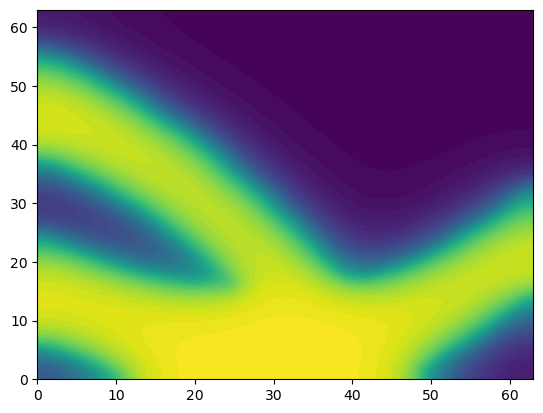

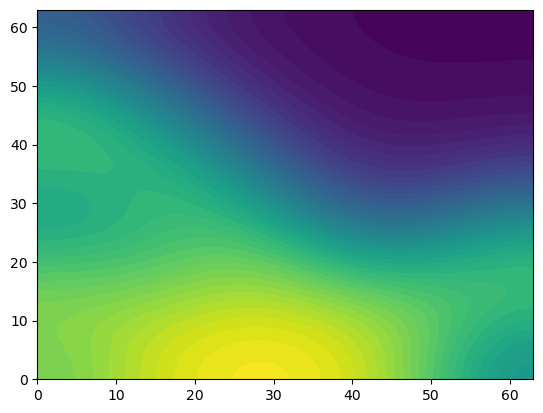

In [70]:
a1 = np.random.uniform(-1,1)
b1 = np.random.normal(0,0.5)
c1 = np.random.normal(0,1)

a2 = a1
b2 = np.random.normal(0,0.5)
c2 = np.random.normal(0,1)

init_cond = np.array([a1, b1, c1, b2, c2])

u_init, u_end = F_operator_HeatEquation(init_cond)

plt.contourf(u_init, levels=50)
plt.show()

plt.contourf(u_end, levels=50)
plt.show()

## Checking the chain

In [329]:
chain = np.load('results_200percentnoise_2/x_chain_2.npy')
chain_vect = np.load('results_200percentnoise_2/x_vect_chain_2.npy')
x_vect = np.load('results_200percentnoise_2/x_vect.npy')

In [330]:
x_vect

array([0.16315854, 0.56057257, 0.04986459])

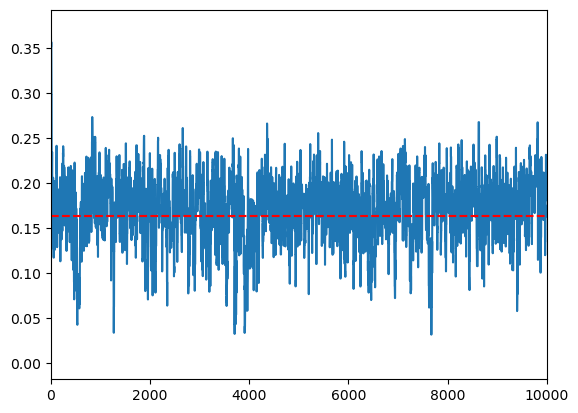

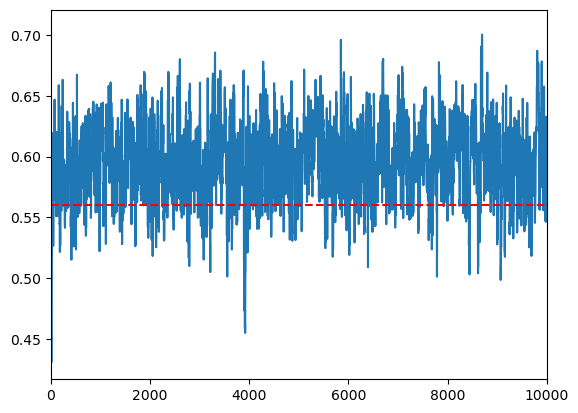

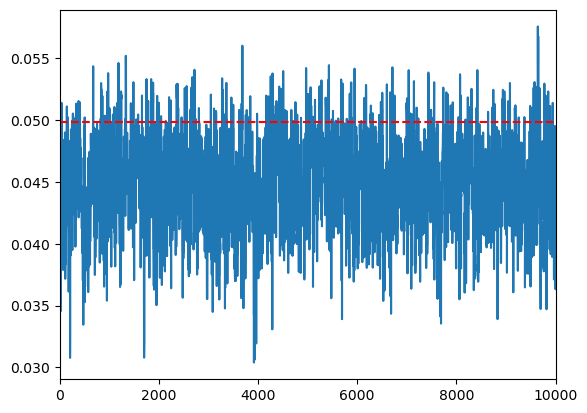

In [331]:
for i in range(chain_vect.shape[1]):
    plt.plot(chain_vect[:,i])
    plt.plot([0,50000], [x_vect[i],x_vect[i]], 'r--')
    plt.xlim([0,10000])
    plt.show()


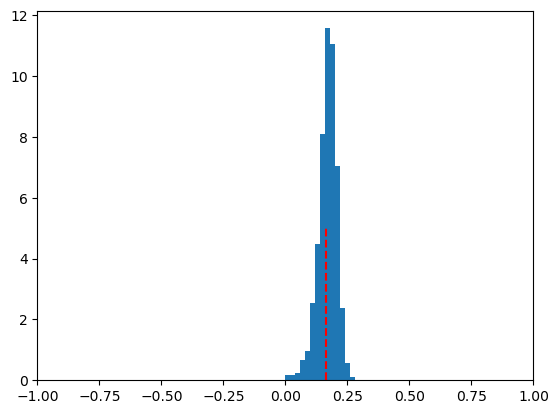

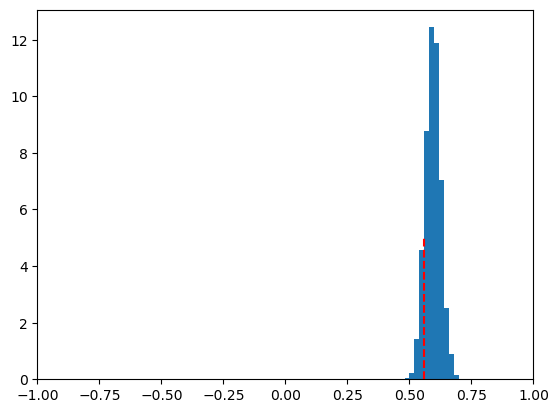

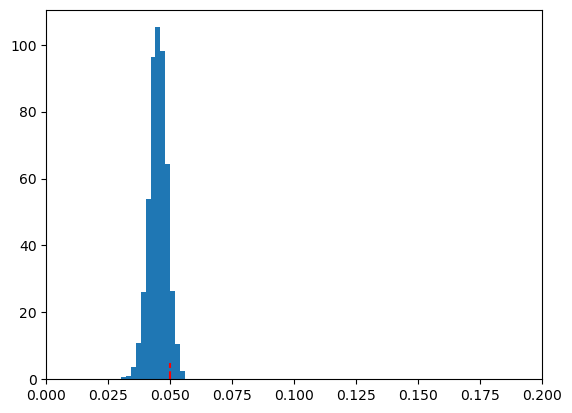

In [332]:
nburning = 1000
for i in range(chain_vect.shape[1]):
    range_ = (-1,1)
    if i == 2:
        range_ = (0.0, 0.2)
    plt.hist(chain_vect[nburning:,i], range=range_, bins=100, density=True)
    plt.plot([x_vect[i],x_vect[i]], [0,5], 'r--')
    plt.xlim(range_)
    plt.show()


In [321]:
x_chain = np.load('results_200percentnoise_2/x_chain_2.npy')

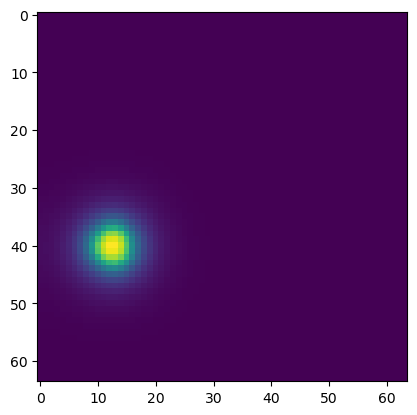

In [322]:
plt.imshow(x_chain[-1])

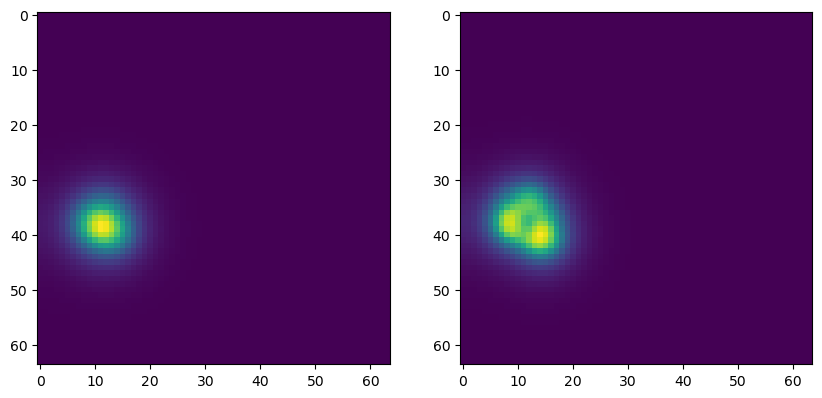

In [323]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.mean(x_chain[1000:], axis=0))
ax[1].imshow(np.std(x_chain[1000:], axis=0))

plt.show()

In [283]:
np.load('results_400percentnoise_1/epsilon.npy')

array(0.1)